# Preparing Time Series from Wide-Form Data

## Task

**Part 1**

- First, you will prepare the dataset for time series analysis:
  - Load in the Zillow Home Value Index dataframe.
     - Note: it is a large file and may take a minute to load.
  - Filter the 4 largest cities into a new dataframe.
    - Tip: the "SizeRank" column has already ranked the cities by size. The larger the city, the smaller the rank value.
     - Therefore the 4 largest cities would have rank values of [0,1,2,3]
  - Melt the data to long-form and prepare it for time series analysis.
    - Convert the melted dates into datetime datatype.
    - Make the datetime column the index.
  - Resample the dataframe as monthly frequency, grouped by City.

**Part 2**

- Once you've prepared the dataframe with the time series data for the 4 largest cities:
  - Plot the home values for all 4 cities. (Hint: use unstack)
     - Make sure to add a title and axis labels.
     - Reformat the y-axis ticks to use thousands of dollars with a "K" at the end. (e.g. "200K, 400K, etc")
        - Hint: use the FuncFormatter from matplotlib.
  - Answer the following 2 questions using pandas:
     - 1) Which City had the highest Typical Home Value at the end of 2008? Which had the least?
        - Hint: You can use the unstacked dataframe or use pd.IndexSlice with the multiindex. 
     - 2) How much did the home values change from November 2008 to December 2008 (in dollars)?
        - Hint: you can use .diff() to calculate the change in values

### Import Libraries

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import missingno as miss
import datetime as dt
import statsmodels.tsa.api as tsa

sns.set_context('notebook',font_scale=0.9)
plt.style.use(['ggplot'])

### Upload Data

In [3]:
filename = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv'
df = pd.read_csv(filename)

In [4]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


In [188]:
top_cities= df.loc[df['SizeRank'][0:4]]
top_cities

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [189]:
top_cities = top_cities.drop(columns=['RegionID','RegionType','StateName','SizeRank'])
top_cities

,RegionName,State,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,257207.0,260310.0,263204.0,266206.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,235513.0,237589.0,240113.0,242421.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,108878.0,108881.0,108834.0,109066.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,167368.0,168826.0,170499.0,172008.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0


In [190]:
id_vars= top_cities.columns[:4]
id_vars

Index(['RegionName', 'State', 'Metro', 'CountyName'], dtype='object')

In [191]:
top_df = pd.melt(top_cities,id_vars=id_vars)
top_df

,RegionName,State,Metro,CountyName,variable,value
0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...
1087,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [192]:
top_df = pd.melt(top_cities,id_vars=id_vars,var_name='Date',value_name='Value')
top_df

,RegionName,State,Metro,CountyName,Date,Value
0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0
...,...,...,...,...,...,...
1087,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2022-08-31,315587.0
1088,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2022-09-30,781622.0
1089,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2022-09-30,966595.0
1090,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2022-09-30,272639.0


In [193]:
#Add a datetime column based on the string in the "date" column
top_df['Date'] = pd.to_datetime(top_df['Date'])
top_df.info()
top_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   RegionName  1092 non-null   object        
 1   State       1092 non-null   object        
 2   Metro       1092 non-null   object        
 3   CountyName  1092 non-null   object        
 4   Date        1092 non-null   datetime64[ns]
 5   Value       1087 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 51.3+ KB


,RegionName,State,Metro,CountyName,Date,Value
0,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,Los Angeles,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,Houston,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,Chicago,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,New York,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-02-29,255517.0


In [194]:
#setting the datetime column as index
top_df = top_df.set_index('Date')
top_df.index

DatetimeIndex(['2000-01-31', '2000-01-31', '2000-01-31', '2000-01-31',
               '2000-02-29', '2000-02-29', '2000-02-29', '2000-02-29',
               '2000-03-31', '2000-03-31',
               ...
               '2022-07-31', '2022-07-31', '2022-08-31', '2022-08-31',
               '2022-08-31', '2022-08-31', '2022-09-30', '2022-09-30',
               '2022-09-30', '2022-09-30'],
              dtype='datetime64[ns]', name='Date', length=1092, freq=None)

In [195]:
#change frequecy to Monthly and group by city
top_df.groupby('RegionName').resample('MS').sum()


C:\Users\Daisy\AppData\Local\Temp\ipykernel_4316\999990589.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_df.groupby('RegionName').resample('MS').sum()


Value
RegionName Date                
Chicago    2000-01-01  166139.0
           2000-02-01  166536.0
           2000-03-01  167368.0
           2000-04-01  168826.0
           2000-05-01  170499.0
...                         ...
New York   2022-05-01  768797.0
           2022-06-01  773944.0
           2022-07-01  777692.0
           2022-08-01  779960.0
           2022-09-01  781622.0

[1092 rows x 1 columns]

In [196]:
top_df2 = top_df.groupby('RegionName').resample("MS").sum()['Value']
top_df2

C:\Users\Daisy\AppData\Local\Temp\ipykernel_4316\1597905629.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  top_df2 = top_df.groupby('RegionName').resample("MS").sum()['Value']


RegionName  Date      
Chicago     2000-01-01    166139.0
            2000-02-01    166536.0
            2000-03-01    167368.0
            2000-04-01    168826.0
            2000-05-01    170499.0
                            ...   
New York    2022-05-01    768797.0
            2022-06-01    773944.0
            2022-07-01    777692.0
            2022-08-01    779960.0
            2022-09-01    781622.0
Name: Value, Length: 1092, dtype: float64

In [197]:
top_df2.index

MultiIndex([( 'Chicago', '2000-01-01'),
            ( 'Chicago', '2000-02-01'),
            ( 'Chicago', '2000-03-01'),
            ( 'Chicago', '2000-04-01'),
            ( 'Chicago', '2000-05-01'),
            ( 'Chicago', '2000-06-01'),
            ( 'Chicago', '2000-07-01'),
            ( 'Chicago', '2000-08-01'),
            ( 'Chicago', '2000-09-01'),
            ( 'Chicago', '2000-10-01'),
            ...
            ('New York', '2021-12-01'),
            ('New York', '2022-01-01'),
            ('New York', '2022-02-01'),
            ('New York', '2022-03-01'),
            ('New York', '2022-04-01'),
            ('New York', '2022-05-01'),
            ('New York', '2022-06-01'),
            ('New York', '2022-07-01'),
            ('New York', '2022-08-01'),
            ('New York', '2022-09-01')],
           names=['RegionName', 'Date'], length=1092)

In [199]:
unstacked = top_df2.unstack(0)
unstacked

RegionName,Chicago,Houston,Los Angeles,New York
Date,,,,
2000-01-01,166139.0,109068.0,234181.0,253690.0
2000-02-01,166536.0,109079.0,234401.0,255517.0
2000-03-01,167368.0,108878.0,235513.0,257207.0
2000-04-01,168826.0,108881.0,237589.0,260310.0
2000-05-01,170499.0,108834.0,240113.0,263204.0
...,...,...,...,...
2022-05-01,312487.0,265558.0,990391.0,768797.0
2022-06-01,314663.0,268901.0,992337.0,773944.0
2022-07-01,315910.0,271059.0,992630.0,777692.0


In [200]:
## Change the default figure size to something wider (12,5)
plt.rcParams['figure.figsize'] = (12,5)

In [201]:
## CREATE ARTISTS FOR MAJOR XTICKS (Years)
# Create a year locator

loc_major_yr = mdates.YearLocator(2)

# Create a year formatter using 4-digit years
fmt_major_yr = mdates.DateFormatter("%Y")


## CREATE ARTISTS FOR MINOR XTICKS ( Months)
# Create a month locator that will add months at 1,4,7,10

loc_minor_3m = mdates.MonthLocator(bymonth=[1,4,7,10])

# Createa monthnformatter that will use 3-letter month names
#fmt_minor_3m = mdates.DateFormatter("%b")

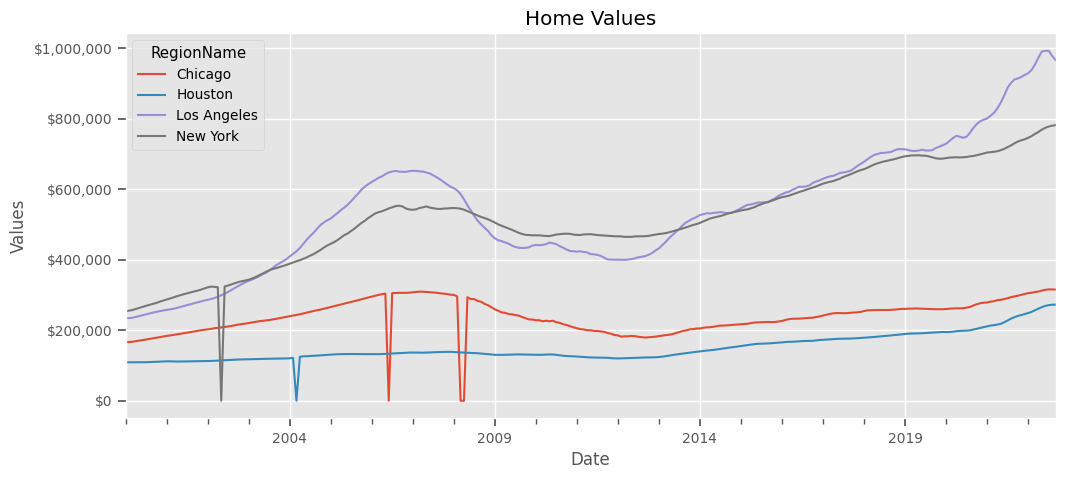

In [237]:
ax = unstacked.plot()
ax.set(ylabel="Values", title='Home Values')
ax.yaxis.set_major_formatter('${x:,.0f}');